In [1]:
%matplotlib inline
from matplotlib import pyplot as plt 

In [2]:
from thesis_v2 import dir_dict
from os.path import join

import pandas as pd
import numpy as np
from scipy.stats import spearmanr

In [3]:
from thesis_v2.configs.model.maskcnn_polished_with_rcnn_k_bl import (
    explored_models_20200218 as param_iterator_obj_k_bl,
    keygen as keygen_k_bl
)

from thesis_v2.configs.model.maskcnn_polished_with_local_pcn import (
    explored_models_summer_2019_certain as param_iterator_obj_local_pcn,
    keygen as keygen_local_pcn
)

In [4]:
from thesis_v2.data.prepared.yuanyuan_8k import get_data, get_indices, get_neural_data
from thesis_v2.data.raw import load_data
from thesis_v2.training.training_aux import load_training_results

In [5]:
# TODO: verify my param_iterator_obj_local_pcn is the same as the original one.
# well, you can achieve this by comparing the output of 
# scripts/training/yuanyuan_8k_a_3day/maskcnn_polished_with_local_pcn/submit_certain_configs_refactored.py
# AND
# scripts/training/yuanyuan_8k_a_3day/maskcnn_polished_with_local_pcn/submit_certain_configs.py

In [6]:
global_vars = {
    'cases': {
        'k_bl': {
            'metric_file': join(dir_dict['analyses'],
                                'metrics_yuanyuan_8k_a_3day+maskcnn_polished_with_rcnn_k_bl+20200218.pkl'),
            'param_iterator': param_iterator_obj_k_bl,
            'keygen': keygen_k_bl,
            'cls_level': 'rcnn_bl_cls',
            'baseline_key': 2,
            'improved_key': 4,
            'fc_size': 14,
            'dir_response': join(
                dir_dict['analyses'],
                'responses_yuanyuan_8k_a_3day+maskcnn_polished_with_rcnn_k_bl+20200218'
            ),
        },
        'local_pcn_50': {
            'metric_file': join(dir_dict['analyses'],
                                'metrics_yuanyuan_8k_a_3day+maskcnn_polished_with_local_pcn+certain_configs.pkl'),
            'metric_filter': {'input_size': 50},
            'param_iterator': param_iterator_obj_local_pcn,
            'param_filter': lambda x: x['input_size'] == 50,
            'keygen': keygen_local_pcn,
            'cls_level': 'pcn_cls',
            'baseline_key': 1,
            'improved_key': (4,5),
            'fc_size': 14,
            'dir_response': join(
                dir_dict['analyses'],
                'responses_yuanyuan_8k_a_3day+maskcnn_polished_with_local_pcn+certain_configs'
            ),
        },
        'local_pcn_100': {
            'metric_file': join(dir_dict['analyses'],
                                'metrics_yuanyuan_8k_a_3day+maskcnn_polished_with_local_pcn+certain_configs.pkl'),
            # only use subset of rows, using pd.DataFrame.xs
            'metric_filter': {'input_size': 100},
            'param_iterator': param_iterator_obj_local_pcn,
            'param_filter': lambda x: x['input_size'] == 100,
            'keygen': keygen_local_pcn,
            'cls_level': 'pcn_cls',
            'baseline_key': 1,
            'improved_key': (4,5),
            'fc_size': 31,
            'dir_response': join(
                dir_dict['analyses'],
                'responses_yuanyuan_8k_a_3day+maskcnn_polished_with_local_pcn+certain_configs'
            ),
        }
    }
}

In [7]:
def load_shared_ground_truth(debug=False):
    # load neural reponses on all.
    neural_data = get_neural_data(('042318', '043018', '051018'), scale=0.5)
    idx_train, idx_val, idx_test = get_indices('a', 'legacy')
    images = load_data('yuanyuan_8k_images', 'a')['images']
    
    print(neural_data.shape, images.shape)
    
    if debug:
        data_gt = get_data('a', 200, 50,
                 ('042318', '043018', '051018'),
                 scale=0.5,
                 seed='legacy')


        assert np.array_equal(data_gt[5], neural_data[idx_test])
        assert np.array_equal(data_gt[3], neural_data[idx_val])
        assert np.array_equal(data_gt[1], neural_data[idx_train])

    return {
        'neural_data': neural_data,
        'idx_train': idx_train,
        'idx_val': idx_val,
        'idx_test': idx_test,
        'images': images,
    }

In [8]:
def load_ground_truth(case_name, case_config):
    
    # load neural responses on test data.
    # go over each config,
    # load responses on test data, collected over each cls.
    # load masks averaged over all configs.
    
    param_iterator_obj = case_config['param_iterator']
    keygen = case_config['keygen']
    fc_size = case_config['fc_size']
    dir_response = case_config['dir_response']
    
    rf_map_all = []
    
    response_map = {}
    param_filter = case_config.get('param_filter', lambda _: True)
    
    count = 0
    
    
    for idx, param in enumerate(param_iterator_obj().generate()):
        if idx % 20 == 0:
            print(idx)
        if not param_filter(param):
            continue
        count += 1
        key = keygen(**{k: v for k, v in param.items() if k not in {'scale', 'smoothness'}})
        
        # load model params.
        result = load_training_results(key, return_model=False,return_checkpoint=True)
        rf_map = result['checkpoint']['model']['moduledict.fc.weight_spatial'].numpy()
        assert rf_map.shape == (79, fc_size, fc_size)
        
        rf_map = abs(rf_map)
        # make each mask sum to one.
        rf_map = rf_map/np.sum(rf_map,axis=(1,2),keepdims=True)
#         print(rf_map.sum())
        rf_map_all.append(rf_map)
    
    
        # get response.
        file_to_load_this = join(dir_response, key, 'test' + '.npy')
        resp = np.load(file_to_load_this)
        assert resp.shape == (1600, 79)
        
        
        cls_this = param[case_config['cls_level']]
        if cls_this not in response_map:
            response_map[cls_this] = []
            
        response_map[cls_this].append(resp)
    
    for cls_value in response_map:
        response_map[cls_value] = np.asarray(response_map[cls_value])
    
    for kk, vv in response_map.items():
        print(kk, vv.shape)
    
    # average over all normalized map
    rf_map_all = np.asarray(rf_map_all).mean(axis=0)
#     print(rf_map_all.sum())
    print(rf_map_all.shape)

    return {
        'nunm_cases': count,
        # all 79 maps.
        'rf_map': rf_map_all,
    }

In [9]:
def plot_scatter(x,y,xlabel,ylabel,title):
    assert x.shape == y.shape
    assert x.ndim == 1
    plt.close('all')
    plt.figure()
    plt.scatter(x,y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

def gen_rank(array_this, reverse):
    # create rank for each of them
    # https://stackoverflow.com/questions/5284646/rank-items-in-an-array-using-python-numpy-without-sorting-array-twice/
    assert array_this.ndim == 1
    temp = array_this.argsort()
    if reverse:
        temp = temp[::-1]
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(array_this.size)
    return ranks

def find_sensitive_neurons(series_this, measure, cls_level, baseline_key, improved_key):
    
    # calculates relative gain of neurons from baseline key to improved key.
    
    baseline_perf = series_this.xs(key=baseline_key, level=cls_level).xs(key=measure,level='measure').sort_index()
    if isinstance(improved_key, int):
        improved_perf = series_this.xs(key=improved_key, level=cls_level).xs(key=measure,level='measure').sort_index()
    else:
        # then summing all together.
        improved_perf = series_this.xs(key=improved_key[0], level=cls_level).xs(key=measure,level='measure').sort_index()
        
        for improved_key_this in improved_key[1:]:
            improved_perf = improved_perf + series_this.xs(key=improved_key_this, level=cls_level).xs(key=measure,level='measure').sort_index()
        
        # all addition and division will work at numpy array level
        improved_perf = improved_perf/len(improved_key)

    assert baseline_perf.index.equals(improved_perf.index)
    
    num_neuron = 79
    
    data = pd.DataFrame({
        'baseline': baseline_perf,
        'improved': improved_perf,
    })
    
    delta_all = np.zeros((num_neuron,), dtype=np.float64)
    bad_case_count = np.zeros((num_neuron,), dtype=np.int64)
    good_case_count = np.zeros((num_neuron,), dtype=np.int64)
    all_case_count = 0
    
    for (k, v) in data.iterrows():
        
        assert isinstance(v['baseline'], np.ndarray)
        assert isinstance(v['improved'], np.ndarray)
        assert v['baseline'].shape == (num_neuron,)
        assert v['improved'].shape == (num_neuron,)
    
        # compute perf gain.
        delta_this = (v['improved'] - v['baseline'])/v['baseline']
        mask_this = v['baseline']!=0
        bad_case_count += np.logical_not(mask_this).astype(np.int64)
        good_case_count += mask_this.astype(np.int64)
        delta_all[mask_this] += delta_this[mask_this]
        all_case_count += num_neuron
        
    
    delta_all /= good_case_count
    print(all_case_count, bad_case_count.sum(), good_case_count.sum(), bad_case_count.sum()/all_case_count)
    return delta_all

def find_sensitive_neurons_wrapper(series_this, cls_level, baseline_key, improved_key, plot=False):
    # using normed or normed does not matter, as that does not affect (relative) detla at all.
    delta_mse = find_sensitive_neurons(series_this, 'mse_normed', cls_level, baseline_key, improved_key)
    delta_cc2 = find_sensitive_neurons(series_this, 'cc2_normed', cls_level, baseline_key, improved_key)
    delta_cc = find_sensitive_neurons(series_this, 'cc_normed', cls_level, baseline_key, improved_key)
    
    # smaller the better,
    rank_mse = gen_rank(delta_mse, reverse=False)
    # bigger better.
    rank_cc = gen_rank(delta_cc, reverse=True)
    # bigger better
    rank_cc2 = gen_rank(delta_cc2, reverse=True)
    
    rank_avg = gen_rank(np.mean([rank_mse, rank_cc, rank_cc2], axis=0), reverse=False)
    
    spear_mse_cc = spearmanr(rank_mse, rank_cc)[0]
    spear_cc_cc2 = spearmanr(rank_cc, rank_cc2)[0]
    spear_mse_cc2 = spearmanr(rank_mse, rank_cc2)[0]
    
    
    spear_mse_cc_debug = spearmanr(-delta_mse, delta_cc)[0]
    spear_cc_cc2_debug = spearmanr(delta_cc, delta_cc2)[0]
    spear_mse_cc2_debug = spearmanr(-delta_mse, delta_cc2)[0]
    
    assert abs(spear_mse_cc_debug-spear_mse_cc) < 1e-5
    assert abs(spear_cc_cc2_debug-spear_cc_cc2) < 1e-5
    assert abs(spear_mse_cc2_debug-spear_mse_cc2) < 1e-5
    
    spear_mse_avg = spearmanr(rank_mse, rank_avg)[0]
    spear_cc_avg = spearmanr(rank_cc, rank_avg)[0]
    spear_cc2_vag = spearmanr(rank_cc2, rank_avg)[0]
    
    # let's plot these scatter plots.
    if plot:
        plot_scatter(rank_mse, rank_cc, 'mse rank', 'cc rank', f'cc vs mse {spear_mse_cc}')
        plot_scatter(rank_cc, rank_cc2, 'cc rank', 'cc2 rank', f'cc2 vs cc {spear_cc_cc2}')
        plot_scatter(rank_mse, rank_cc2, 'mse rank', 'cc2 rank', f'cc2 vs mse {spear_mse_cc2}')
        plot_scatter(rank_mse, rank_avg, 'mse rank', 'avg rank', f'avg vs mse {spear_mse_avg}')
        plot_scatter(rank_cc, rank_avg, 'mse rank', 'avg rank', f'avg vs cc {spear_cc_avg}')
        plot_scatter(rank_cc2, rank_avg, 'mse rank', 'avg rank', f'avg vs cc2 {spear_cc2_vag}')
    
    print(spear_mse_cc, spear_cc_cc2, spear_mse_cc2, spear_mse_avg, spear_cc_avg, spear_cc2_vag)
    
    
    
    return {
        'mse': rank_mse,
        'cc': rank_cc,
        'cc2': rank_cc2,
        'avg': rank_avg,
        'delta_mse': delta_mse,
        'delta_cc2': delta_cc2,
        'delta_cc': delta_cc,
    }

In [10]:
def process_one_case(case_name, case_config):
    # load data
    print(f'process case {case_name}')
    df = pd.read_pickle(case_config['metric_file'])
    
    # only work on test data.
    df = df.xs('test', level='subset')
    
    
    # filter based on metric_filter
    metric_filter = case_config.get('metric_filter', None)
    if metric_filter is not None:
        for kk, vv in metric_filter.items():
            df = df.xs(vv, level=kk)
    
    # collect neurons top ranked and worst ranked under various measures.
    # I will use of two: mse, and avg(mse, cc, cc2)
    # this part is easy to config.
    
    neuron_ranking_info = find_sensitive_neurons_wrapper(df['val_per'],
                                                         cls_level=case_config['cls_level'],
                                                        baseline_key=case_config['baseline_key'],
                                                         improved_key=case_config['improved_key'],
                                                        plot=True)
#     print(neuron_ranking_info)
    
    
    # load relevance ground truth data, such as neural response,
    # mask of each network (averaged across different circles),
    # (not upsampled yet)
#     gt_dict = load_ground_truth(case_name, case_config)
    
    
    
    # for each ranking mode,
    # then plot.
    
    # I will calculate everything,
    # but visualize top 10 neurons, bottom 10 neurons.
    #
    # for each neuron, I show
    #  0) image mask.
    #  1) the best responding images over all 8K images
    #  2) response distribution over all data
    #  3) top 20 images that contribute most to recurrence, and response improvement
    #  4) top 20 images that contribute least to recurrence, and response improvement
    #  
    # all the visualization is done on an area centered around mask and covers 90% of the energy in the mask.

In [11]:
def main():
    for name, config in global_vars['cases'].items():
        process_one_case(name, config)

process case k_bl
30336 0 30336 0.0
30336 0 30336 0.0
30336 0 30336 0.0


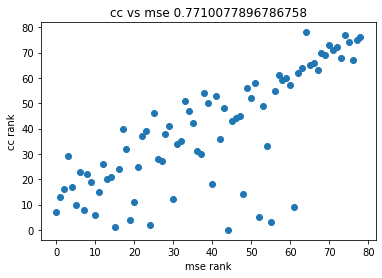

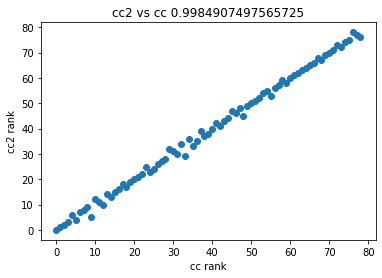

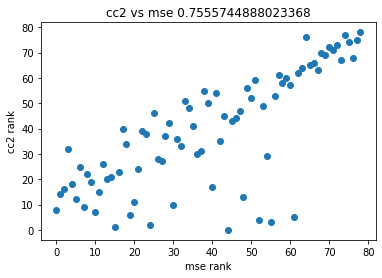

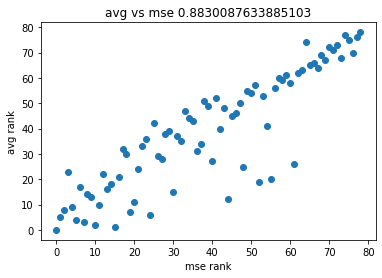

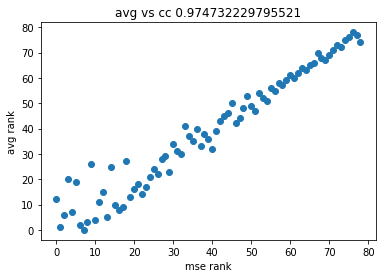

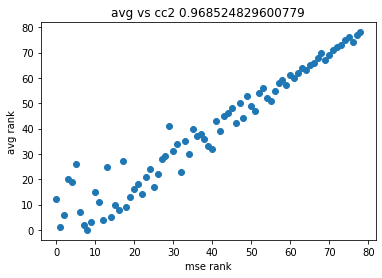

0.7710077896786758 0.9984907497565725 0.7555744888023368 0.8830087633885103 0.974732229795521 0.968524829600779
process case local_pcn_50
15168 0 15168 0.0
15168 0 15168 0.0
15168 0 15168 0.0


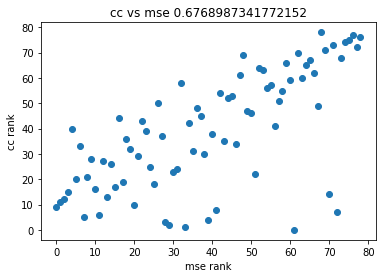

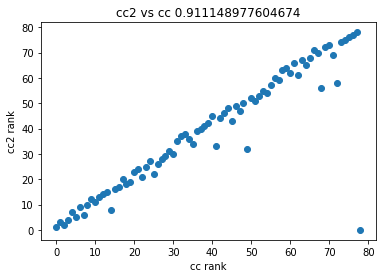

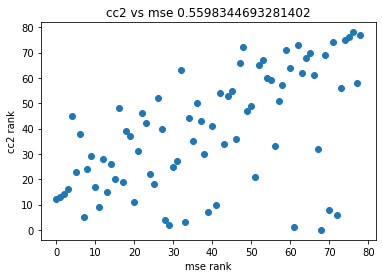

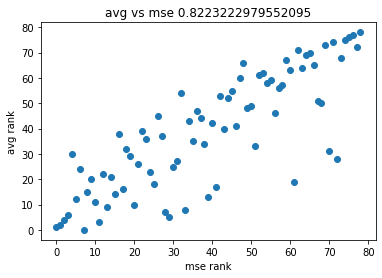

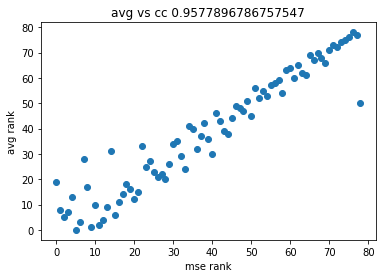

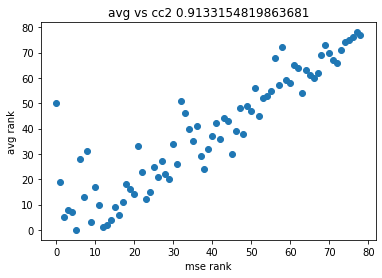

0.6768987341772152 0.911148977604674 0.5598344693281402 0.8223222979552095 0.9577896786757547 0.9133154819863681
process case local_pcn_100
15168 0 15168 0.0
15168 0 15168 0.0
15168 0 15168 0.0


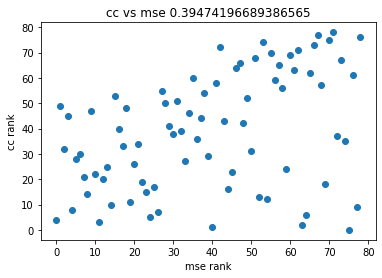

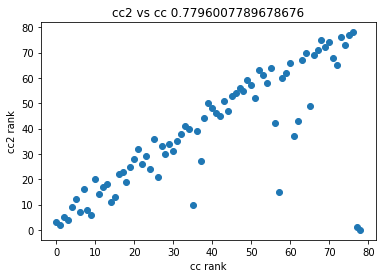

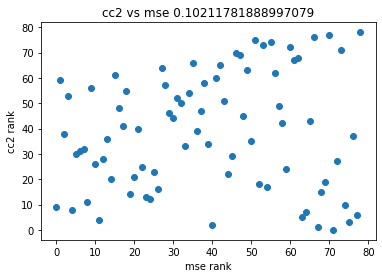

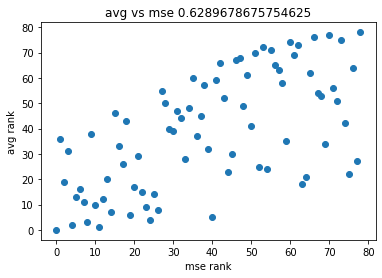

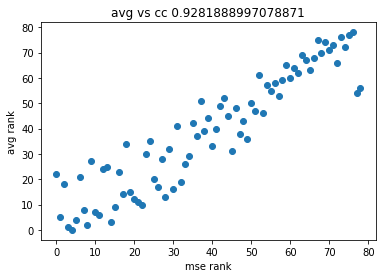

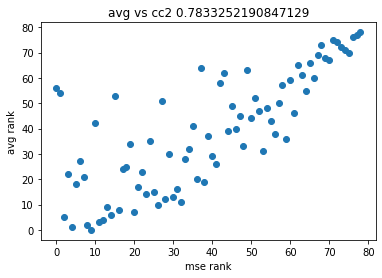

0.39474196689386565 0.7796007789678676 0.10211781888997079 0.6289678675754625 0.9281888997078871 0.7833252190847129


In [12]:
main()